In [2]:
# Import required libraries
import pandas as pd

# Load the dataset
df = pd.read_csv("spam.csv", encoding='latin-1')

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Check the shape of the dataset
print("\nDataset shape:", df.shape)

# Display the column names
print("\nColumn Names:", df.columns)

# Since the dataset has unnecessary columns, we'll clean it up
df = df[['v1', 'v2']]  # Keeping only the necessary columns

# Rename columns for better understanding
df.columns = ['label', 'text']

# Check for class distribution (ham vs spam)
print("\nClass distribution:")
print(df['label'].value_counts())


First 5 rows of the dataset:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Dataset shape: (5572, 5)

Column Names: Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


In [3]:
# Import necessary libraries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re

# Step 1: Convert 'ham' and 'spam' to binary labels (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Step 2: Clean the text (remove non-alphabet characters, convert to lowercase)
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text

df['text'] = df['text'].apply(clean_text)

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Step 4: Use TF-IDF to convert the text into numerical representation
tfidf = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for simplicity
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# Check the shape of the transformed data
print("\nShape of TF-IDF transformed training data:", X_train_tfidf.shape)
print("Shape of TF-IDF transformed test data:", X_test_tfidf.shape)



Shape of TF-IDF transformed training data: (4457, 5000)
Shape of TF-IDF transformed test data: (1115, 5000)


In [4]:
# Import TensorFlow and Keras
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Step 1: Build the neural network
model = Sequential()

# Input layer (5000 features from TF-IDF)
model.add(Dense(512, input_shape=(5000,), activation='relu'))  # 512 neurons, relu activation
model.add(Dropout(0.5))  # Dropout for regularization

# Hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer (1 neuron, since it's binary classification)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary output

# Step 2: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the model
history = model.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_data=(X_test_tfidf, y_test))

model.save('spam_model.h5')  # Save the trained model to disk

# Step 10: Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Model and vectorizer saved successfully.")
# Step 4: Evaluate the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


ModuleNotFoundError: No module named 'distutils'

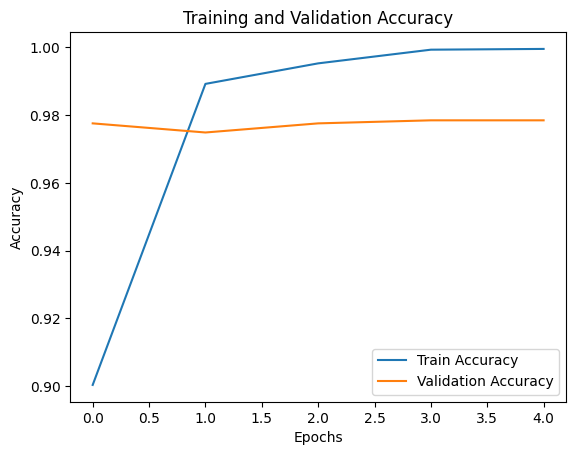

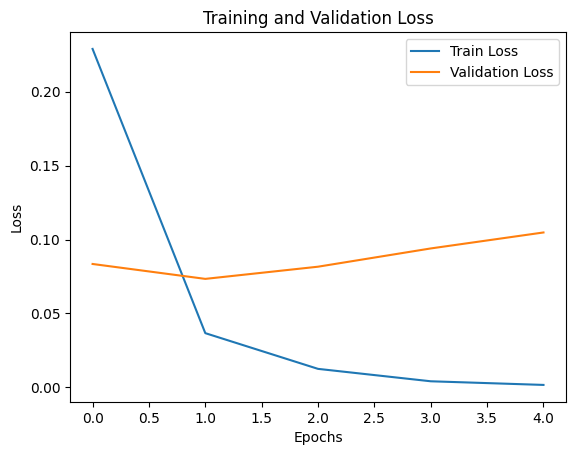

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


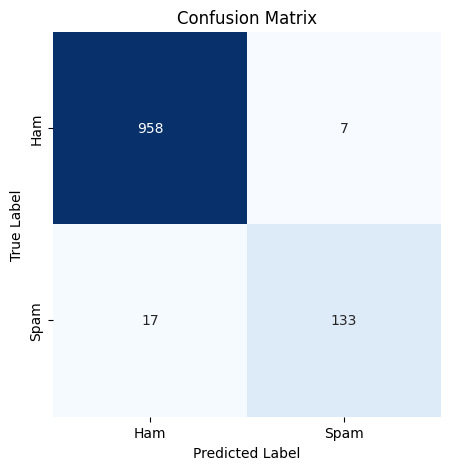

              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       965
        Spam       0.95      0.89      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = (model.predict(X_test_tfidf) > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


In [ ]:
import tensorflow as tf
import pickle

# Load the saved model and vectorizer
model = tf.keras.models.load_model('spam_model.h5')
with open('tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

def predict_message(message):
    # Transform the message using the TF-IDF vectorizer
    transformed_message = vectorizer.transform([message])
    
    # Get the model's prediction
    prediction = model.predict(transformed_message)
    
    # Interpret the prediction (above 0.5 is spam, below is ham)
    if prediction > 0.5:
        return "This message is classified as SPAM."
    else:
        return "This message is classified as HAM."

# Infinite loop to keep taking user input
while True:
    # Take input from the user
    user_input = input("Enter a message to classify (or type 'exit' to quit): ")
    
    # Exit condition
    if user_input.lower() == 'exit':
        print("Exiting the spam detector. Goodbye!")
        break
    
    # Predict and print the result
    result = predict_message(user_input)
    print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
This message is classified as SPAM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
This message is classified as HAM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This message is classified as SPAM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
This message is classified as HAM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
This message is classified as SPAM.
Exiting the spam detector. Goodbye!
